## Neural Style Transfer using Pytorch and VGG19

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch as t
import torch.nn.functional as F
from torchvision import transforms, models


Here we load two images, one for styling and one for the content to style on

In [2]:
tfms = transforms.Compose([transforms.Resize((256, 256), Image.BICUBIC), transforms.ToTensor()])
device = t.device('cuda') if t.cuda.is_available() else 'cpu'

style_img = tfms(Image.open('data/style.jpg'))[None].to(device, t.float)
content_img = tfms(Image.open('data/content.jpg'))[None].to(device, t.float)

In [3]:
def imshow(tensor, title=None):
    plt.imshow(transforms.ToPILImage()(tensor.cpu()[0]))
    plt.title(title)
    plt.show()

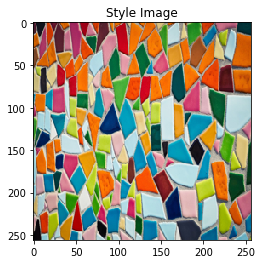

In [4]:
imshow(style_img, title='Style Image')

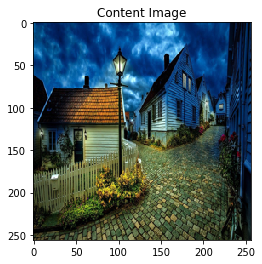

In [5]:
imshow(content_img, title='Content Image')

#### ContentLoss just does MSE of x and y at a certain layer, and holds the loss for back prop later, while returning x to pass off to the next layer. This is useful for the part that makes sure that the final resulting image will have content resembling the content img

In [6]:
class ContentLoss(nn.Module):
    def __init__(self, content_target):
        super(ContentLoss, self).__init__()
        self.content_target = content_target

    def forward(self, x):
        self.loss = F.mse_loss(x, self.content_target)
        return x


#### StyleLoss is more interesting. It's like ContentLoss, but instead does MSE of x and y at a certain layer using gram matrices. The reason why we use Gram Matrices is because of this

CNN layers happen to capture features, such as edges, color hues, etc, using activations from filters, also called feature maps or channels. The feature maps are simpler in the earlier layers and get more complex later down the layers. However, if channels capture features, then we should leverage them in capturing style somehow. That's what we hope to accomplish using Gram Matrices.

When you flatten your image tensor to dimensions c x (h times w), then each row is the channel vector of the image.
Then once you do a matrix multiplication of that flattened tensor, and the transpose of it, i.e that tensor with dimensions (h times w) x c, then you get a gram matrix. The gram matrix(dimensions c x c) now shows correlations between all pairs of channels/features of the image, thus representing the style. Here's a vivid example of why.

Imagine you had two similar images of really wavy clouds and one image of just the sun. Now say that we have three channels, one captures wavy edges, one captures yellow, the last captures white.

Now let's say we made them into flattened c x (h times w) tensors. How do we find style from this? We correlate each channel to the other channels for all channels, and a easy way to show correlation between two vectors is using dot product. For example's sake, say we have these vectors


|         | wavy channel       | yellow channel     | white channel      |   |
|---------|--------------------|--------------------|--------------------|---|
| clouds1 | [1, 2, -2, -1]     | [0, 0, 0.2, 0.3]   | [2, 2, 1.5, 1.5]   |   |
| clouds2 | [0.5, 2, -1.5, -1] | [0, 0.2, 0.1, 0.1] | [1.5, 1, 1, 2.5]   |   |
| sun     | [0, 1, 1, -0.2]    | [1.5, 2.5, 1, 1.5] | [0, 0.2, 0.1, 0.1] |   |


Now look at how the dot product looks like for each images

clouds1
[[10.0000, -0.7000,  1.5000],
 [-0.7000,  0.1300,  0.7500],
 [ 1.5000,  0.7500, 12.5000]])

clouds2
[[ 7.5000,  0.1500, -1.2500],
 [ 0.1500,  0.0600,  0.5500],
 [-1.2500,  0.5500, 10.5000]])

sun
[[ 2.0400,  3.2000,  0.2800],
 [ 3.2000, 11.7500,  0.7500],
 [ 0.2800,  0.7500,  0.0600]])
 
 
Now notice something. clouds1 and clouds2 have simlar dot products, while sun has a very different one. It would be very hard for clouds to get similar dot products to that of the sun, unless the channels resembled something more to that of a sun, which is also why clouds1 and clouds2 have similar dot products. However, it isn't totally impossible, as row 3, column 2 of all three matrices are similar. This allows some flexibility in the styling, as different channel weights can somehow form a dot product that numerically is similar. However IN GENERAL OR IN MAJORITY, the dot products in the gram matrices, as you can see, is supposed to capture a style representation since it's hard to get the majority of the matrices to similar numbers without having similar channel vector interactions(dot product). And if you have similar patterns or styling in images, you are likely to have similar overlaps in the channel vectors, which then when taken in correlation vs all the other channels through the gram product, will come up with some dot product, which embeds styling taken into account for that channel vs all other, instead of just the pure content, because this higher level embedding through channel interactions is what we need to capture stylistic things. Finally, do that for all the possible dot products, and you have a matrix representing style.

It's important to note that you are will be doing this over many layers and seeing how far our styling is from the target styling. This will capture more information about styling, since channels at different layers capture different things, and also will somewhat add some more flexibility in the final outcome. 

Lastly, in reality, there are more channels that the contrived example, especially if you sum up the amount throughout each layer of the CNN as well as much bigger vectors per channel, since (h times w) is probably gonna be a lot bigger.

I hope this makes things clear! Let's continue to the code

In [7]:
class StyleLoss(nn.Module):
    def __init__(self, style_target):
        super(StyleLoss, self).__init__()
        self.style_target = self.gram_matrix(style_target).detach()

    def gram_matrix(self, x):
        b, c, h, w = x.shape
        features = x.view(b * c, w * h)
        g_matrix = t.mm(features, features.t())
        return g_matrix.div(b * c * w * h)

    def forward(self, x):
        gram_prod = self.gram_matrix(x)
        self.loss = F.mse_loss(gram_prod, self.style_target)
        return x


In [8]:
class Vgg19Norm(nn.Module):
    def __init__(self):
        super(Vgg19Norm, self).__init__()
        self.mean = t.tensor([[[0.485]], [[0.456]], [[0.406]]]).to(device)
        self.std = t.tensor([[[0.229]], [[0.224]], [[0.225]]]).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std


In [9]:
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()
content_losses, style_losses = [], []
model = nn.Sequential(Vgg19Norm())

Now after we loaded the vgg19 model, we are going to make our model out of that. First thing we did is add the 
normalization layer, then we are going to keep adding from the vgg model to our model, along with 
our corresponding content and style losses per layer, then slice off the layers after our last content and style 
loss layer

In [10]:
i = 0
for layer in vgg19.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
    if isinstance(layer, nn.ReLU):
        layer = nn.ReLU()

    name = f'{layer.__class__.__name__}_{i}'
    model.add_module(name, layer)

    content_layers = ['Conv2d_4']
    style_layers = ['Conv2d_1', 'Conv2d_2', 'Conv2d_3', 'Conv2d_4', 'Conv2d_5']
    if name in content_layers:
        content_target = model(content_img).detach()
        content_loss = ContentLoss(content_target)
        model.add_module(f'content_loss_{i}', content_loss)
        content_losses.append(content_loss)

    if name in style_layers:
        style_target = model(style_img).detach()
        style_loss = StyleLoss(style_target)
        model.add_module(f'style_loss_{i}', style_loss)
        style_losses.append(style_loss)

for i, e in reversed(list(enumerate(model))):
    if isinstance(e, (ContentLoss, StyleLoss)):
        break

model = model[:i + 1]


In [11]:
# we pass in the output_img as something you directly take the gradient on
# in order to make it something that will give you small content losses and style losses
# when passing it through the network. That gradient for the output_img
# is computed from backward on the style loss and content loss

In [12]:
output_img = content_img.clone()
optimizer = t.optim.LBFGS([output_img.requires_grad_()])

In [13]:
i = 0
while i <= 300:
    # LBFGS requires closure
    def closure():
        global i
        output_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(output_img)
        style_loss = 0
        content_loss = 0
        
        # here we count in the style and content losses we mentioned at the beginning
        # which were computed and saved from passing through the model
        for sl in style_losses:
            style_loss += sl.loss
        for cl in content_losses:
            content_loss += cl.loss

        # the bigger the style lambda, the less fine grainy details you might lose from the content
        style_lambda = 1000000
        content_lambda = 1
        style_loss *= style_lambda
        content_loss *= content_lambda

        loss = style_loss + content_loss
        loss.backward()

        i += 1
        if i % 50 == 0:
            print('iteration: ', i)
            print(f'style loss : {style_loss.item()}\tcontent loss: {content_loss.item()}\n')

        return loss

    optimizer.step(closure)
output_img.data.clamp_(0, 1);


iteration:  50
style loss : 1353.448486328125	content loss: 51.03255081176758

iteration:  100
style loss : 381.9963684082031	content loss: 58.23628234863281

iteration:  150
style loss : 181.5911102294922	content loss: 60.79936218261719

iteration:  200
style loss : 101.01661682128906	content loss: 62.403221130371094

iteration:  250
style loss : 65.27766418457031	content loss: 62.566795349121094

iteration:  300
style loss : 45.55245590209961	content loss: 62.28395080566406



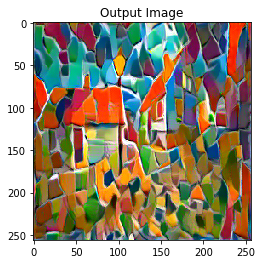

In [14]:
imshow(output_img, title='Output Image')
plt.show()
